In [20]:
import math
import glob
import pandas as pd

# Define some constants
SILVER_PATH = '/usr/datalake/silver'
PATTERN = 'StormEvents_details-ftp_v1.0_d*.csv'
storm_columns_to_use = ['STATE_FIPS', 'EVENT_TYPE', 'CZ_FIPS', 'CZ_NAME', 'BEGIN_DATE_TIME',
                        'MAGNITUDE', 'TOR_F_SCALE', 'BEGIN_LOCATION', 'BEGIN_LAT', 'BEGIN_LON']
feature_names_columns_to_use = ['feature_name', 'state_numeric', 'prim_lat_dec', 'prim_long_dec', 'date_edited', 'county_name']
county_names_columns_to_use = ['state_numeric', 'county_name', 'county_numeric', 'prim_lat_dec', 'prim_long_dec']
county_fips_columns_to_use = ['state_numeric', 'county_numeric', 'county_numeric', 'prim_lat_dec', 'prim_long_dec']
event_types = ['Tornado', 'Hail', 'Thunderstorm Wind']

In [25]:
def list_files() -> list[str]:
    search = f'{SILVER_PATH}/stormevents/csvfiles/{PATTERN}'
    
    return glob.glob(search)

def read_filtered_csv(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename, usecols=storm_columns_to_use)
    df = pd.DataFrame(df[df['EVENT_TYPE'].isin(event_types)])
    df = pd.DataFrame(df[df['STATE_FIPS'] != 99])

    # Effective
    df['effective'] = pd.to_datetime(df['BEGIN_DATE_TIME'], format='%d-%b-%y %H:%M:%S')
    df = df.drop('BEGIN_DATE_TIME', axis=1)

    return df

def read_feature_names_csv() -> pd.DataFrame:
    df = pd.read_csv(f'{SILVER_PATH}/fedcodes/FederalCodes.csv', usecols=feature_names_columns_to_use)
    df = df.sort_values(by='date_edited')
    df['date_edited'] = pd.to_datetime(df['date_edited'])
    df['feature_name'] = df['feature_name'].str.upper()
    df['county_name'] = df['county_name'].str.upper()
    df = df.groupby(['feature_name', 'state_numeric']).first()
    
    return df

def read_county_names_csv() -> pd.DataFrame:
    df = pd.read_csv(f'{SILVER_PATH}/fedcodes/FederalCodes.csv', usecols=county_names_columns_to_use)
    df['county_name'] = df['county_name'].str.upper()
    df = df.groupby(['state_numeric', 'county_numeric', 'county_name']).mean()
    
    return df

def read_county_fips_csv() -> pd.DataFrame:
    df = pd.read_csv(f'{SILVER_PATH}/fedcodes/FederalCodes.csv', usecols=county_fips_columns_to_use)
    df = df.groupby(['state_numeric', 'county_numeric']).mean()
    
    return df

def apply_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(read_feature_names_csv(), how='left',
                         left_on=['STATE_FIPS', 'CZ_NAME', 'BEGIN_LOCATION'],
                         right_on=['state_numeric', 'county_name', 'feature_name'])
    df['BEGIN_LAT'] = df['BEGIN_LAT'].combine_first(df['prim_lat_dec'])
    df['BEGIN_LON'] = df['BEGIN_LON'].combine_first(df['prim_long_dec'])
    df = df.drop(labels=['date_edited', 'prim_lat_dec', 'prim_long_dec', 'county_name'], axis=1)

    return df

def apply_county_names(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(read_county_names_csv(), how='left',
                         left_on=['STATE_FIPS', 'CZ_NAME'],
                         right_on=['state_numeric', 'county_name'])
    df['BEGIN_LAT'] = df['BEGIN_LAT'].combine_first(df['prim_lat_dec'])
    df['BEGIN_LON'] = df['BEGIN_LON'].combine_first(df['prim_long_dec'])
    df = df.drop(labels=['prim_lat_dec', 'prim_long_dec'], axis=1)

    return df

def apply_county_fips(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(read_county_fips_csv(), how='left',
                         left_on=['STATE_FIPS', 'CZ_FIPS'],
                         right_on=['state_numeric', 'county_numeric'])
    df['BEGIN_LAT'] = df['BEGIN_LAT'].combine_first(df['prim_lat_dec'])
    df['BEGIN_LON'] = df['BEGIN_LON'].combine_first(df['prim_long_dec'])
    df = df.drop(labels=['prim_lat_dec', 'prim_long_dec'], axis=1)

    return df

def aggregate_files():
    results = []

    for filename in list_files():
        df = read_filtered_csv(filename)
        df = apply_features(df)
        df = apply_county_names(df)
        df = apply_county_fips(df)
        df['TOR_F_SCALE'] = df['TOR_F_SCALE'].apply(lambda x: decode_tornado_rating(x))

        results.append(df)

        print(f"Processed {filename}")

    result = pd.concat(results)
    
    return result

def decode_tornado_rating(value: any) -> float:
    if type(value) == float:
        if math.isnan(value):
            return value
        raise(f'unexpected float value: {value}')
    if value[0] == 'F':
        return float(value[1])
    if value == 'EFU':
        return 0.
    if value[0] == 'E':
        return float(value[2])
    raise('something unexpected happened')

In [26]:
severe_df = aggregate_files();

Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2000_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2001_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2002_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2003_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2004_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2005_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2006_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2007_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2008_c20250520.csv
Processed /usr/datalake/silver/stormevents/csvfiles\StormEvents_details-ftp_v1.0_d2009_c202

In [27]:
severe_df.shape

(721960, 10)

In [28]:
severe_df.head()

,STATE_FIPS,EVENT_TYPE,CZ_FIPS,CZ_NAME,MAGNITUDE,TOR_F_SCALE,BEGIN_LOCATION,BEGIN_LAT,BEGIN_LON,effective
0,28.0,Thunderstorm Wind,123,SCOTT,NaN,NaN,FORKVILLE,32.45000,-89.65000,2000-08-03 14:10:00
1,28.0,Thunderstorm Wind,69,KEMPER,NaN,NaN,DE KALB,32.70000,-88.65000,2000-08-09 14:05:00
2,28.0,Thunderstorm Wind,23,CLARKE,NaN,NaN,SHUBUTA,31.86667,-88.71667,2000-08-09 16:15:00
3,47.0,Thunderstorm Wind,155,SEVIER,NaN,NaN,PIGEON FORGE,35.78333,-83.55000,2000-02-13 23:10:00
4,37.0,Thunderstorm Wind,39,CHEROKEE,NaN,NaN,MARBLE,35.18333,-83.93333,2000-02-13 23:15:00


In [29]:
severe_df[pd.isnull(severe_df['BEGIN_LAT']) | pd.isnull(severe_df['BEGIN_LON'])]

,STATE_FIPS,EVENT_TYPE,CZ_FIPS,CZ_NAME,MAGNITUDE,TOR_F_SCALE,BEGIN_LOCATION,BEGIN_LAT,BEGIN_LON,effective
7730,6.0,Thunderstorm Wind,96,S SIERRA MTNS,NaN,NaN,NaN,NaN,NaN,2000-06-28 12:00:00
11078,6.0,Thunderstorm Wind,96,S SIERRA MTNS,NaN,NaN,NaN,NaN,NaN,2001-07-08 11:00:00
20792,6.0,Thunderstorm Wind,96,S SIERRA MTNS,NaN,NaN,NaN,NaN,NaN,2001-09-25 03:10:00
23352,96.0,Thunderstorm Wind,2,ST. CROIX,NaN,NaN,ST. CROIX,NaN,NaN,2001-10-14 23:30:00
3541,6.0,Thunderstorm Wind,96,S SIERRA MTNS,NaN,NaN,NaN,NaN,NaN,2002-03-07 15:30:00
25081,96.0,Thunderstorm Wind,2,ST. CROIX,NaN,NaN,COUNTYWIDE,NaN,NaN,2002-09-16 00:00:00
25082,96.0,Thunderstorm Wind,1,ST. THOMAS/ST. JOHN & ISLANDS,NaN,NaN,COUNTYWIDE,NaN,NaN,2002-09-16 00:00:00


<Axes: >

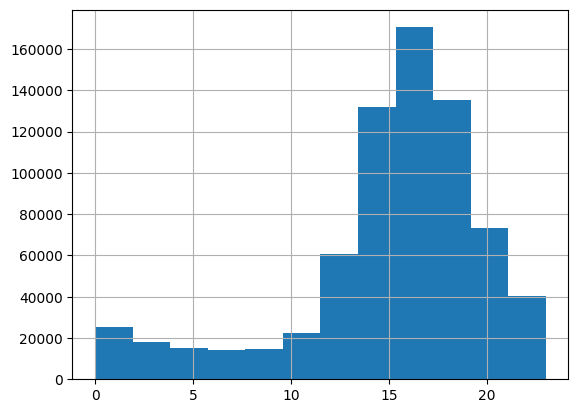

In [ ]:
severe_df['effective'].dt.hour.hist(bins=24)

<Axes: >

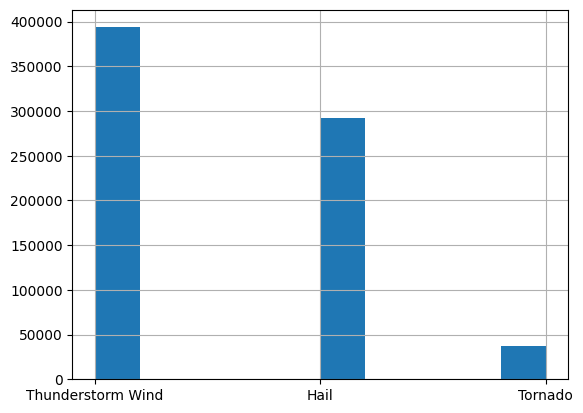

In [31]:
severe_df['EVENT_TYPE'].hist()

In [32]:
severe_df.to_csv(f'{SILVER_PATH}/stormevents/csvfiles/severe_dillon.csv', index=False)

<Axes: >

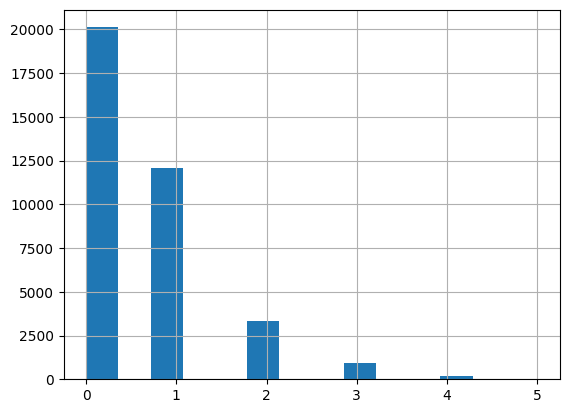

In [33]:
severe_df['TOR_F_SCALE'].hist(bins=14)

In [34]:
severe_df['TOR_F_SCALE'].unique()

array([nan,  1.,  0.,  2.,  3.,  4.,  5.])